In [1]:
# Long Short-Term Memory for Sentiment Analysis task
# Define necessary packages

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from keras.utils import np_utils
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from wordcloud import WordCloud
from many_stop_words import get_stop_words
from scipy import interp
from itertools import cycle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec
import gensim
import seaborn as sn
from gensim.utils import simple_preprocess
from tensorflow.keras.utils import to_categorical
import pickle
import h5py
from time import time
np.random.seed(7)

/Users/bednar/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Initializing process
print("Initializing...")
initial_time = time()

#Load dataset
filename = 'Data/DatasetHate.csv'
dataset = pd.read_csv(filename, delimiter = ";", nrows=200000)
dataset.apply(np.random.permutation, axis=1)
print(dataset.head())

# Delete unused column
del dataset['length']

# Delete All NaN values from columns -> ['description','rate']
dataset = dataset[dataset['description'].notnull() & dataset['rate'].notnull()]

# Set all strings as lower case letters
dataset['description'] = dataset['description'].str.lower()


# Split data into training, test and validation set (60:20:20)
X = dataset['description']
y = dataset['rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Print X, y train, test and validation shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))
print("y_val shape: " + str(y_val.shape))

Initializing...
                                         description  length  rate
0  Dla mnie faworytem do tytułu będzie Cracovia. ...    78.0     0
1  @anonymized_account @anonymized_account Brawo ...    82.0     0
2  @anonymized_account @anonymized_account Super,...   125.0     0
3  @anonymized_account @anonymized_account Musi. ...    67.0     0
4    Odrzut natychmiastowy, kwaśna mina, mam problem    47.0     0
X_train shape: (7065,)
X_test shape: (2209,)
X_val shape: (1767,)
y_train shape: (7065,)
y_test shape: (2209,)
y_val shape: (1767,)


In [3]:
# Load existing word2vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('nkjp.txt', binary=False)

In [4]:
embedding_matrix = word2vec_model.get_normed_vectors()

In [5]:
# Define embedding matrix
#embedding_matrix = word2vec_model.wv.syn0
#embedding_matrix = word2vec_model.syn0
print('Shape of embedding matrix: ', embedding_matrix.shape)
# (2 123 132, 100)

Shape of embedding matrix:  (2123132, 100)


In [6]:
# Vectorize X_train and X_test to 2D tensor
top_words = embedding_matrix.shape[0]

# Define max lenght of sentence and number of classes (negative, neutral and positive)
mxlen = 30
nb_classes = 3

tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

Found 18744 unique tokens.


In [8]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [9]:
"""Emedding layer: this layer can only be used as the first layer in a model.
   Arguments:
        input_dim: int > 0.
        output_dim: int >=0.
    
"""
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1])

"""Define Neural Network Architecture.
   Layers:
        embedding_layer: (embedding_matrix.shape[0], embedding_matrix.shape[1])
        LSTM1: (neurons, dropout, recurrent_dropout, return_sequences)
        LSTM2: (neurons, dropout, recurrent_dropout)
        Dense1: Full-connected layer (neurons, activation function)
        Dense2: Full-connected layer (neurons on output)
        Activation: (activation function)
        
   Parameters:
        optimizer: is the selection of a best element from some set of available alternatives.
        loss: is a function that maps an event or values of one or move variables onto a real number
              intuitively representing some "cost" associated with the event.
        metrics: is a function that is used to judge the performance of your model.
        batch_size: defines number of samples that going to be propagated through the network.
        nb_epoch: One Epoch is when an entire dataset is passed forward and backward throught
                  the neural network only once.
        validation_data: (x_val, y_val) on which to evaluate the loss and any model metrics
                         at the end of each epoch.
"""
nb_epoch = 5
batch_size = 32

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         212313200 
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 212,484,403
Trainable params: 212,484,403
Non-trainable params: 0
__________________________________________

In [12]:
t0 = time()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)

# Save model as file with .h5 extension
print('Save model...')
model.save('Models/test.h5')
print('Saved model to disk...')

# Save word index as pickle file
print('Save Word index...')
output = open('Models/finalwordindex.pkl', 'wb')
pickle.dump(word_index, output)
print('Saved word index to disk...')

t1 = time()
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

Epoch 1/5
221/221 [==============================] - 992s 4s/step - loss: 0.2159 - accuracy: 0.9096 - val_loss: 0.1979 - val_accuracy: 0.9111
Epoch 2/5
221/221 [==============================] - 1264s 6s/step - loss: 0.1292 - accuracy: 0.9301 - val_loss: 0.2157 - val_accuracy: 0.9168
Epoch 3/5
221/221 [==============================] - 1156s 5s/step - loss: 0.0614 - accuracy: 0.9646 - val_loss: 0.2397 - val_accuracy: 0.9055
Epoch 4/5
221/221 [==============================] - 1027s 5s/step - loss: 0.0437 - accuracy: 0.9724 - val_loss: 0.3244 - val_accuracy: 0.9185
Epoch 5/5
56/56 [==============================] - 1s 14ms/step - loss: 0.3265 - accuracy: 0.9078
Save model...
Saved model to disk...
Save Word index...
Saved word index to disk...
Test Loss: 32.65%
Test Accuracy: 90.78%


Training completed in :5443.800379991531 s.


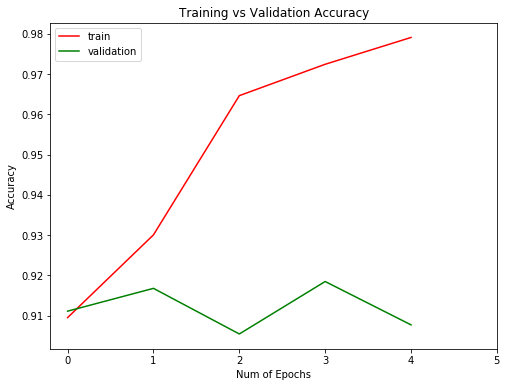

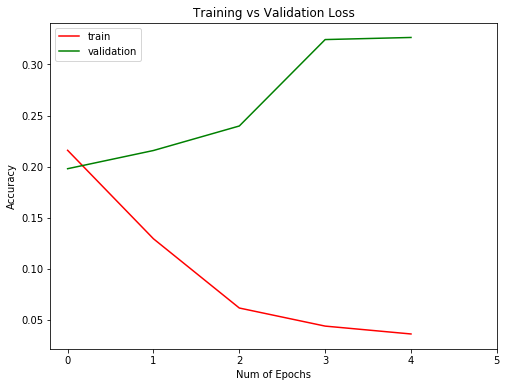

In [16]:
"""
# Vizualizing model structure

from keras_sequential_ascii import sequential_model_to_ascii_printout

sequential_model_to_ascii_printout(model)
"""

print("Training completed in :" + str(t1-t0) + " s.")

# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(rnn.history['accuracy'],'r')
plt.plot(rnn.history['val_accuracy'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train', 'validation'])
plt.savefig('Plots/10a.png')

plt.figure(1)
plt.plot(rnn.history['loss'],'r')
plt.plot(rnn.history['val_loss'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Loss")
plt.legend(['train', 'validation'])
plt.savefig('Plots/10b.png')
plt.show()

In [14]:
rnn.history

{'loss': [0.21590736508369446,
  0.12921959161758423,
  0.061387915164232254,
  0.04366888478398323,
  0.035954397171735764],
 'accuracy': [0.909554123878479,
  0.930077850818634,
  0.9646142721176147,
  0.9723991751670837,
  0.9790516495704651],
 'val_loss': [0.19787435233592987,
  0.215717613697052,
  0.23973649740219116,
  0.32440996170043945,
  0.3264690637588501],
 'val_accuracy': [0.9111488461494446,
  0.9168081283569336,
  0.9054895043373108,
  0.9185059666633606,
  0.9077532291412354]}

In [17]:
# Apply Precision-Recall
y_pred = model.predict(X_val)

# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_val]
print(yy_true)

yy_scores = [np.argmax(i) for i in y_pred]
print(yy_scores)

print("Recall: " + str(recall_score(yy_true, yy_scores, average='weighted')))
print("Precision: " + str(precision_score(yy_true, yy_scores, average='weighted')))
print("F1 Score: " + str(f1_score(yy_true, yy_scores, average='weighted')))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 

0 1610
1 51
2 106
[[1571   27   12]
 [  39    3    9]
 [  68    8   30]]


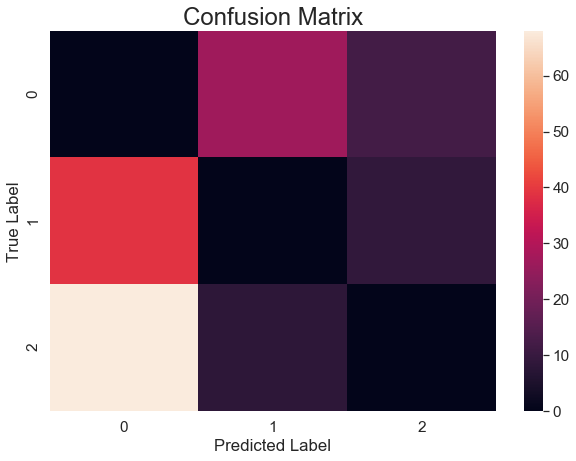

In [21]:
# Apply Confusion matrix

#y_pred = np.argmax(y_pred, axis=1)

for ix in range(3):
    print(ix, confusion_matrix(np.argmax(y_val, axis=1), y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
print(cm)

# Visualizing of confusion matrix
cm[0,0] = 0
cm[1,1] = 0
cm[2,2] = 0

df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=False)
sn.set_context("poster")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('Plots/confusionMatrixFinal.png')
plt.show()

/Users/bednar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


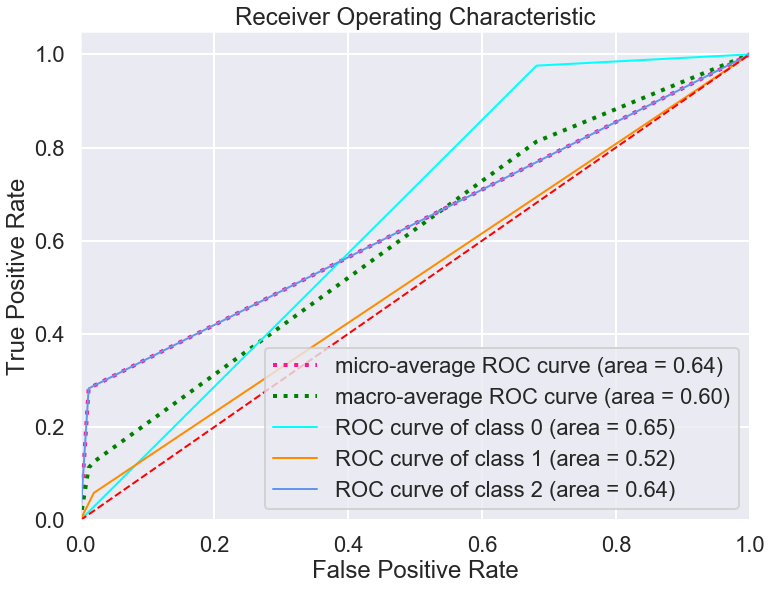

In [94]:
#### ROC Curve ####

# Compute ROC curve and ROC area for each class

n_classes = 3
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(yy_true))[:, i], np.array(pd.get_dummies(yy_scores))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(yy_true))[:, i], np.array(pd.get_dummies(yy_scores))[:, i])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,9))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Plots/ROCcurveFinal.png')
plt.show()

In [96]:
X_custom_text = [
    "Ta hołota jest już wszędzie",
    "Ty głupi pajacu puknij się w łeb",
    "Żaluzje sobie palancie koszulkę SS i.idz na marsz nazioli",
    "Cześć, co u was?",
    "Zapraszam Was na obiad",
    "Głąbie, czego chcesz",
    "Ten mecz w sumie był całkiem niezły. Nie spodziewałem się tego.",
    "Piłka nożna dla kibiców a nie pseudo dziennikarzy."
]

X_custom_text = ["@anonymized_account "+x for x in X_custom_text]

decoder = {
    0: "Nieszkodliwy",
    1: "CYBERPRZEMOC",
    2: "MOWA NIENAWIŚCI"
}

sequences_custom = tokenizer.texts_to_sequences(X_custom_text)
X_custom = sequence.pad_sequences(sequences_custom, maxlen=mxlen)

y_pred_custom = model.predict(X_custom)

classes_coded = y_pred_custom.argmax(axis=1)

pred_decoded = [decoder[x] for x in classes_coded]

for i in range(len(X_custom_text)):
        print(X_custom_text[i].replace("@anonymized_account","").strip())
        print("\t",pred_decoded[i])
        print()

Ta hołota jest już wszędzie
	 CYBERPRZEMOC

Ty głupi pajacu puknij się w łeb
	 CYBERPRZEMOC

Żaluzje sobie palancie koszulkę SS i.idz na marsz nazioli
	 CYBERPRZEMOC

Cześć, co u was?
	 Nieszkodliwy

Zapraszam Was na obiad
	 Nieszkodliwy

Głąbie, czego chcesz
	 Nieszkodliwy

Ten mecz w sumie był całkiem niezły. Nie spodziewałem się tego.
	 Nieszkodliwy

Piłka nożna dla kibiców a nie pseudo dziennikarzy.
	 MOWA NIENAWIŚCI

